# Support Vector Machines for text classification

In [3]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import re
import os
import string

from pathlib import Path

from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## Data preprocessing

### First, define auxiliary functions

In [4]:
def remove_emojis(text: str) -> str:
    """ Removes emojis from the given text """
    return re.sub(r"[^\w\s,!?@#áéíóúÁÉÍÓÚñÑ]", "", text)

def clear_tokens(tokens_list: list) -> None:
    """ Removes punctuation symbols from the given tokens list """
    # Traverse the list backwards to avoid logic problems with pop() and indexes order
    for i in range(len(tokens_list) - 1, -1, -1):
        if tokens_list[i] in string.punctuation:
            tokens_list.pop(i)
    return

### Tokenize with TweetTokenizer and vectorize with TF-IDF

In [5]:
def tokenize_and_vectorize(data_path: str, 
                           treat_emojis: bool=False,
                           verbose: bool=False) -> tuple:
    """ Tokenizes the messages from all the users and computes vectors from them """
    path            = Path(data_path)
    all_users_data  = []
    tokenizer       = TweetTokenizer()
    vectorizer      = TfidfVectorizer()
    users_order     = [] # List that stores the users in the order that are processed, for merging with the target

    # Iterate through the JSON data folder
    for element in path.iterdir():
        if element.is_file():
            user_id = re.findall(pattern=r"[0-9]+", string=element.name)[0]
            users_order.append(user_id)

            # Some execution verbose
            if verbose:
                print(f"Tokenizing messages from user: {user_id}")

            # Open and read the current JSON file
            with open(data_path + f'/{element.name}') as json_file:
                json_data = json.load(fp=json_file)

                if treat_emojis:
                    # Emojis must be deleted from the messages
                    messages = [ remove_emojis(str(record['message'])) for record in json_data ]

                else:
                    # Preserve emojis in the messages
                    messages = [ str(record['message']) for record in json_data ]

                # Apply the TweetTokenizer algorithm
                tokenized = [ tokenizer.tokenize(m) for m in messages ]

                # Remove punctuation symbols tokens
                for i, t in enumerate(tokenized):
                    clear_tokens(tokens_list=t)

                    # If the resulting list is empty, then remove it
                    if len(t) == 0:
                        tokenized.pop(i)
                
                # Join the tokens of a single message, since that is what expects the implementation of TF-IDF
                user_document = " ".join(tokenized[0])
                for i in range(1, len(tokenized)):
                    tokens_joined = " ".join(tokenized[i])
                    user_document += " " + tokens_joined
            
                # Merge the previous data with the current user's
                all_users_data.append(user_document)

    # Vectorize all the messages with the TF-IDF and return the data as a Pandas DataFrame
    X  = vectorizer.fit_transform(all_users_data)
    df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return df, users_order

In [6]:
# Get the data from all users
data_path                  = os.getcwd() + '/data/task1/train/subjects/'
df_vectorized, users_order = tokenize_and_vectorize(data_path=data_path, treat_emojis=True, verbose=False)

# Show the first five elements
print(df_vectorized.head())

    00  000  0000  0000000  00000000000  00000085  00000110  0000014  0000017  \
0  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
1  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
2  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
3  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
4  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   

   000003  ...  últimamente  últimas  último  últimos   ún  única  únicamente  \
0     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
1     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
2     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
3     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
4     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   

   único  únicos  útiles  

### Build the supervised dataset (with the target variable)

In [7]:
# Get the data from the target variable
target_path = os.getcwd() + '/data/task1/train/gold_task1.txt'
target_col  = pd.read_csv(filepath_or_buffer=target_path, delimiter=',').to_numpy()
users_tags  = { re.findall(r"[0-9]+", target_col[i][0])[0]: target_col[i][1] for i in range(len(target_col)) }

# Create a copy of the dataset
df_supervised = df_vectorized.copy()

# Create the target column in order and add it to the Pandas DataFrame
target = np.array([ users_tags[user_id] for user_id in users_order ], np.int8)
df_supervised.insert(loc=len(df_supervised.columns), column='Target', value=target)

# Show the first five rows
print(df_supervised.head())

    00  000  0000  0000000  00000000000  00000085  00000110  0000014  0000017  \
0  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
1  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
2  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
3  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
4  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   

   000003  ...  últimas  último  últimos   ún  única  únicamente  único  \
0     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
1     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
2     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
3     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
4     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   

   únicos  útiles  Target  
0     0.0     0.0       0  
1     

## Training the SVM - Task 1

### Base model

In [74]:
# Perform the train-test split
X, y = df_supervised.drop(columns=['Target'], axis=1), df_supervised['Target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y, 
                                                    shuffle=True)

# Train the SVM
clf = LinearSVC()
clf.fit(X_train, y_train)

# Evaluate with test
y_pred = clf.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"SVM accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

SVM accuracy: 0.7
              precision    recall  f1-score   support

           0       0.68      0.78      0.73        36
           1       0.72      0.62      0.67        34

    accuracy                           0.70        70
   macro avg       0.70      0.70      0.70        70
weighted avg       0.70      0.70      0.70        70



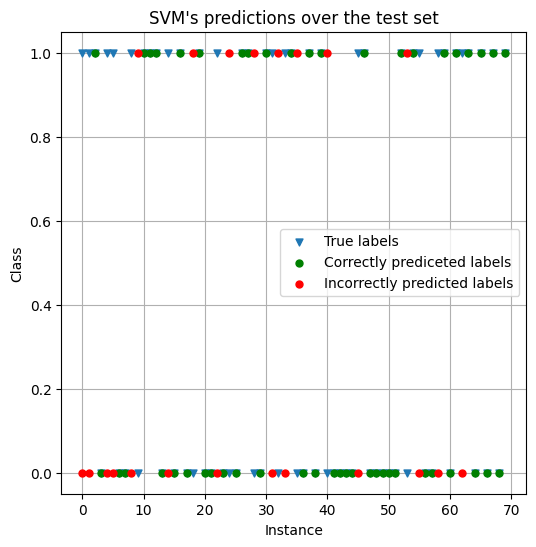

In [75]:
# Plot the predictions over the test set
y_correct_indexes, y_incorrect_indexes = np.where(y_pred == y_test), np.where(y_pred != y_test)
y_correct, y_incorrect = y_pred[y_correct_indexes], y_pred[y_incorrect_indexes]

plt.figure(figsize=(6, 6))
plt.title("SVM's predictions over the test set")
plt.scatter(range(len(y_test)), y_test, s=25.0, marker='v', label='True labels', zorder=2)
plt.scatter(y_correct_indexes, y_correct, s=25.0, label='Correctly prediceted labels', zorder=2, c='green')
plt.scatter(y_incorrect_indexes, y_incorrect, s=25.0, label='Incorrectly predicted labels', zorder=2, c='red')
plt.xlabel("Instance")
plt.ylabel("Class")
plt.grid(True)
plt.legend()
plt.show()

### Hyper-parameter search

In [76]:
param_grid = {
    'C': [ 0.1, 1, 2, 3, 7 ],
    'gamma': [ 'scale', 0.01, 0.001, 0.0001 ],
    'kernel': [ 'linear', 'rbf' ]
}

svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# CV results
print("Best hyper-parameters found:")
print(grid.best_params_)
print("\nBest cross validation score:")
print(grid.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

In [ ]:
# Evaluate with test
clf    = grid.best_estimator_
y_pred = clf.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"SVM accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

SVM accuracy: 0.69
              precision    recall  f1-score   support

           0       0.67      0.74      0.70        53
           1       0.70      0.63      0.67        52

    accuracy                           0.69       105
   macro avg       0.69      0.69      0.68       105
weighted avg       0.69      0.69      0.68       105



In [68]:
param_grid = {
    'n_estimators': [100, 200, 300],         # Número de árboles
    'max_depth': [None, 10, 20, 30],         # Profundidad máxima
    'min_samples_split': [2, 5, 10],         # Mínimos samples para dividir un nodo
    'min_samples_leaf': [1, 2, 4],           # Mínimos samples en una hoja
    'bootstrap': [True, False]               # Si usar bootstrapping
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross validation
    scoring='accuracy',
    n_jobs=-1,  # usa todos los núcleos disponibles
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [62]:
# Evaluate with test
clf    = grid.best_estimator_
y_pred = clf.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"RF accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

RF accuracy: 0.71
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        36
           1       0.72      0.68      0.70        34

    accuracy                           0.71        70
   macro avg       0.71      0.71      0.71        70
weighted avg       0.71      0.71      0.71        70



### Evaluation with test

## Training the final model - Task 1

## Training the SVM - Task 2

### Base model

### Hyper-parameter search

### Evaluation with test

## Training the final model - Task 2